# Simulation of MB vs SR vs MF in RL 2-step task

Running MB Agent...
Running MF Agent...
Running SR Agent...


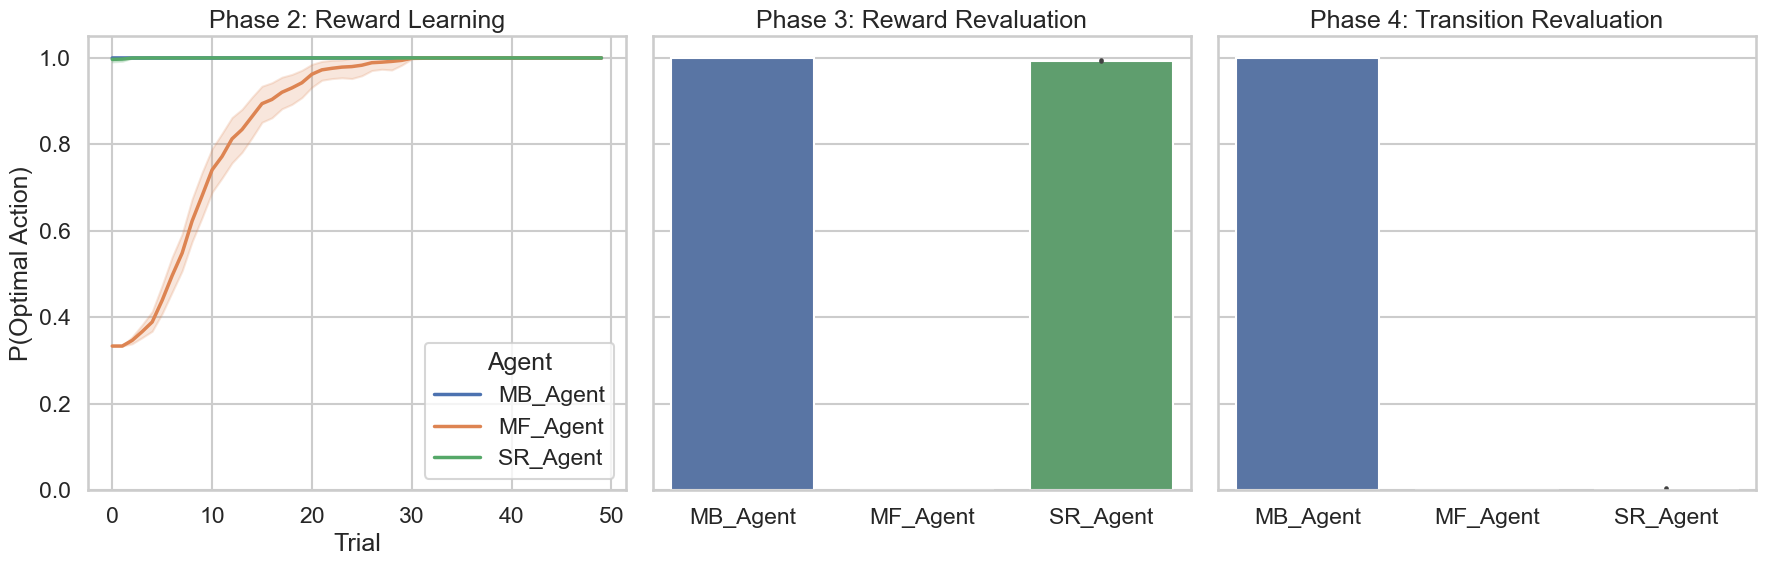


--- Summary: Mean Probability of Best Choice ---
Phase                Agent   
2. Reward Learning   MB_Agent    9.999948e-01
                     MF_Agent    8.597865e-01
                     SR_Agent    9.998744e-01
3. Reward Reval      MB_Agent    9.999999e-01
                     MF_Agent    2.215136e-11
                     SR_Agent    9.933930e-01
4. Transition Reval  MB_Agent    1.000000e+00
                     MF_Agent    2.227289e-11
                     SR_Agent    4.359627e-03
Name: ProbBest, dtype: float64


In [17]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# ==========================================
# 1. SETUP & CONSTANTS
# ==========================================
np.random.seed(55)
sns.set_theme(style="whitegrid", context="talk")

# Task Constants
N_STATES = 10 
# 0: Start
# 1, 2, 3: Middle States (Step 2)
# 4, 5, 6: Terminal States (Outcomes)
N_ACTIONS = 3 # A0, A1, A2

class ThreeBranchEnv:
    def __init__(self):
        self.reset_structure()
        
    def reset_structure(self):
        # T: State x Action x Next_State
        self.T = np.zeros((N_STATES, N_ACTIONS, N_STATES))
        
        # --- Step 1: Start (0) -> Middle (1, 2, 3) ---
        # A0 -> S1 (Strong)
        # A1 -> S2 (Strong)
        # A2 -> S3 (Strong)
        
        # Probabilistic transitions (80/10/10 noise)
        self.T[0, 0, :] = [0, 0.8, 0.1, 0.1, 0,0,0, 0,0,0] 
        self.T[0, 1, :] = [0, 0.1, 0.8, 0.1, 0,0,0, 0,0,0]
        self.T[0, 2, :] = [0, 0.1, 0.1, 0.8, 0,0,0, 0,0,0]

        # --- Step 2: Middle -> Terminal (4, 5, 6) ---
        # Initially: 
        # S1 (Path A) -> S4
        # S2 (Path B) -> S5
        # S3 (Path C) -> S6
        
        self.T[1, :, 4] = 1.0
        self.T[2, :, 5] = 1.0
        self.T[3, :, 6] = 1.0
        
        # Terminal absorbing
        for s in [4, 5, 6]:
            self.T[s, :, s] = 1.0

        # Rewards: Defined externally
        self.R = np.zeros(N_STATES)

    def step(self, state, action):
        probs = self.T[state, action]
        if probs.sum() == 0:
            return state, 0
        next_state = np.random.choice(N_STATES, p=probs)
        reward = self.R[next_state]
        return next_state, reward

    def transition_revaluation(self):
        # Clear old mappings
        self.T[2, :, :] = 0
        self.T[3, :, :] = 0
        
        # New mappings
        self.T[2, :, 6] = 1.0 # S2 now goes to Bad outcome
        self.T[3, :, 5] = 1.0 # S3 now goes to Good outcome

# ==========================================
# 2. AGENTS
# ==========================================

class Agent:
    def __init__(self, alpha=0.1, gamma=1.0, beta=5.0, **kwargs):
        self.alpha = alpha
        self.gamma = gamma
        self.beta = beta
        
    def softmax(self, q):
        e = np.exp(self.beta * (q - np.max(q)))
        return e / np.sum(e)
    
    def choice_prob(self, state):
        q = self.get_q(state)
        return self.softmax(q)

    def select_action(self, state):
        probs = self.choice_prob(state)
        return np.random.choice(N_ACTIONS, p=probs)

class MF_Agent(Agent):
    def __init__(self, n_states, n_actions, **kwargs):
        self.n_states = n_states
        self.n_actions = n_actions
        super().__init__(**kwargs)
        self.Q = np.zeros((N_STATES, N_ACTIONS))
        
    def get_q(self, state):
        return self.Q[state]
    
    def update(self, s, a, r, s_next):
        # SARSA / Q-Learning mix
        max_next = np.max(self.Q[s_next])
        td = r + self.gamma * max_next - self.Q[s, a]
        self.Q[s, a] += self.alpha * td
        
    def set_rewards(self, r_map):
        pass 

class MB_Agent(Agent):
    def __init__(self, n_states, n_actions, **kwargs):
        self.n_states = n_states
        self.n_actions = n_actions
        super().__init__(**kwargs)
        # Transition Model
        self.T_model = np.ones((N_STATES, N_ACTIONS, N_STATES)) / N_STATES
        self.R_model = np.zeros(N_STATES)

    def get_q(self, state):
        # Value Iteration on demand
        V = np.zeros(N_STATES)
        
        # 1. Terminal Values
        for s in range(N_STATES):
            V[s] = self.R_model[s]
            
        # 2. Backward induction (simplified for DAG task)
        # Step 2 States (1,2,3)
        for s in [1, 2, 3]:
            qs = []
            for a in range(N_ACTIONS):
                qs.append(np.dot(self.T_model[s, a], V))
            V[s] = self.R_model[s] + self.gamma * np.max(qs)
            
        # Step 1 State (0)
        q_0 = []
        for a in range(N_ACTIONS):
            q_0.append(np.dot(self.T_model[0, a], V))
            
        if state == 0: return np.array(q_0)
        return np.zeros(N_ACTIONS)

    def update(self, s, a, r, s_next):
        # Update Reward
        self.R_model[s_next] = r
        
        # Update Transition (Delta rule)
        one_hot = np.zeros(N_STATES)
        one_hot[s_next] = 1.0
        self.T_model[s, a] += self.alpha * (one_hot - self.T_model[s, a])
        
    def set_rewards(self, r_map):
        for s, r in r_map.items():
            self.R_model[s] = r

class SR_Agent(Agent):
    def __init__(self, n_states, n_actions, **kwargs):
        self.n_states = n_states
        self.n_actions = n_actions
        super().__init__(**kwargs)
        # M: Successor Representation
        self.M = np.zeros((N_STATES, N_ACTIONS, N_STATES))
        # Init identity
        for s in range(N_STATES):
            for a in range(N_ACTIONS):
                self.M[s, a, s] = 1.0
        
        self.R_w = np.zeros(N_STATES) 

    def get_q(self, state):
        # Q = M * R
        q_vals = []
        for a in range(N_ACTIONS):
            q_vals.append(np.dot(self.M[state, a], self.R_w))
        return np.array(q_vals)

    def update(self, s, a, r, s_next):
        self.R_w[s_next] = r
        
        # SR TD Update
        q_next = self.get_q(s_next)
        best_a = np.argmax(q_next)
        
        target = np.zeros(N_STATES)
        target[s] = 1.0 
        target += self.gamma * self.M[s_next, best_a]
        
        error = target - self.M[s, a]
        self.M[s, a] += self.alpha * error
        
    def set_rewards(self, r_map):
        for s, r in r_map.items():
            self.R_w[s] = r

# ==========================================
# 3. EXPERIMENT LOOP
# ==========================================

def run_simulation(agent_cls, n_sims=50):
    
    data = []
    
    for sim in range(n_sims):
        env = ThreeBranchEnv()
        agent = agent_cls(n_states=N_STATES, n_actions=N_ACTIONS)
        
        # --- PHASE 1: Latent Learning ---
        for _ in range(100):
            s = 0
            a = np.random.choice(3)
            s_mid, _ = env.step(s, a)
            agent.update(s, a, 0, s_mid)
            
            a_mid = np.random.choice(3)
            s_end, _ = env.step(s_mid, a_mid)
            agent.update(s_mid, a_mid, 0, s_end)

        # --- PHASE 2: Reward Learning ---
        rewards_p2 = {4: 10, 5: 0, 6: 0}
        env.R = np.zeros(N_STATES)
        env.R[4] = 10
        agent.set_rewards(rewards_p2)
        
        optimal_action = 0
        
        for t in range(50):
            s = 0
            probs = agent.choice_prob(s)
            data.append({'Phase': '2. Reward Learning', 'Trial': t, 'ProbBest': probs[optimal_action], 'Agent': agent_cls.__name__})
            
            a = agent.select_action(s)
            s_mid, r = env.step(s, a)
            agent.update(s, a, r, s_mid)
            
            a_mid = agent.select_action(s_mid)
            s_end, r = env.step(s_mid, a_mid)
            agent.update(s_mid, a_mid, r, s_end)

        # --- PHASE 3: Reward Revaluation ---
        rewards_p3 = {4: 0, 5: 10, 6: 0}
        env.R = np.zeros(N_STATES)
        env.R[5] = 10
        agent.set_rewards(rewards_p3)
        optimal_action = 1
        
        for t in range(20):
            probs = agent.choice_prob(0)
            data.append({'Phase': '3. Reward Reval', 'Trial': t, 'ProbBest': probs[optimal_action], 'Agent': agent_cls.__name__})
            pass

        # --- PHASE 4: Transition Revaluation ---
        env.transition_revaluation()
        optimal_action = 2
        
        # Re-learning trials (Transition only, God Mode for MB)
        for _ in range(20):
            s_mid = np.random.choice([1, 2, 3])
            a_mid = np.random.choice(3)
            s_end, r = env.step(s_mid, a_mid)
            agent.update(s_mid, a_mid, r, s_end)
            
        if isinstance(agent, MB_Agent):
            agent.T_model[2, :, :] = 0  
            agent.T_model[3, :, :] = 0  
            agent.T_model[2, 0, 6] = 1.0 
            agent.T_model[3, 0, 5] = 1.0
            
        for t in range(20):
            probs = agent.choice_prob(0)
            data.append({'Phase': '4. Transition Reval', 'Trial': t, 'ProbBest': probs[optimal_action], 'Agent': agent_cls.__name__})

    return pd.DataFrame(data)

# ==========================================
# 4. EXECUTION
# ==========================================
print("Running MB Agent...")
df_mb = run_simulation(MB_Agent, n_sims=100)
print("Running MF Agent...")
df_mf = run_simulation(MF_Agent, n_sims=100)
print("Running SR Agent...")
df_sr = run_simulation(SR_Agent, n_sims=100)

df_all = pd.concat([df_mb, df_mf, df_sr])

# ==========================================
# 5. PLOTTING
# ==========================================

# Create a figure with 3 subplots (1 row, 3 columns)
fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True)

# Plot 1: Reward Learning (Line Plot)
sns.lineplot(
    data=df_all[df_all['Phase'] == '2. Reward Learning'],
    x='Trial', y='ProbBest', hue='Agent',
    ax=axes[0], linewidth=2.5
)
axes[0].set_title('Phase 2: Reward Learning')
axes[0].set_ylabel('P(Optimal Action)')
axes[0].set_ylim(0, 1.05)

# Plot 2: Reward Revaluation (Bar Plot)
sns.barplot(
    data=df_all[df_all['Phase'] == '3. Reward Reval'],
    x='Agent', y='ProbBest', hue='Agent',
    ax=axes[1], errorbar='se', dodge=False
)
axes[1].set_title('Phase 3: Reward Revaluation')
axes[1].set_ylabel('')
axes[1].set_xlabel('')

# Plot 3: Transition Revaluation (Bar Plot)
sns.barplot(
    data=df_all[df_all['Phase'] == '4. Transition Reval'],
    x='Agent', y='ProbBest', hue='Agent',
    ax=axes[2], errorbar='se', dodge=False
)
axes[2].set_title('Phase 4: Transition Revaluation')
axes[2].set_ylabel('')
axes[2].set_xlabel('')

plt.tight_layout()
plt.show()

# Print Summary Stats
print("\n--- Summary: Mean Probability of Best Choice ---")
print(df_all.groupby(['Phase', 'Agent'])['ProbBest'].mean())